#  **5. Evaluacion de metricas**  







In [1]:
# ==== 5.1 Cargar modelos y utilidades ====
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
)

# Rutas robustas a /models (funciona si corres desde docs/ o desde la raíz)
CWD = Path.cwd()
PROJECT = CWD if CWD.name != "docs" else CWD.parent
MODELS = PROJECT / "models"

def load_if_exists(path: Path):
    if path.exists():
        print(f"Cargando {path.name}")
        return joblib.load(path)
    print(f"⚠️ No existe: {path.name}")
    return None

candidates = {
    "RandomForest": load_if_exists(MODELS / "rf_best.joblib"),
    "XGBoost":      load_if_exists(MODELS / "xgb_best.joblib"),
    "LightGBM":     load_if_exists(MODELS / "lgbm_best.joblib"),
}
# filtra los que sí cargaron
candidates = {k:v for k,v in candidates.items() if v is not None}
print("Modelos cargados:", list(candidates.keys()))


Cargando rf_best.joblib
Cargando xgb_best.joblib
Cargando lgbm_best.joblib
Modelos cargados: ['RandomForest', 'XGBoost', 'LightGBM']


In [3]:
# ==== Cargar X_test, y_test de forma robusta ====
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

CWD = Path.cwd()
PROJECT = CWD if CWD.name != "docs" else CWD.parent
DATA = PROJECT / "data"
INTERIM = DATA / "interim"
PROCESSED = DATA / "processed"
RAW = DATA / "raw"

TARGET = "Churn"  # ajusta si tu columna objetivo se llama distinto

def _try_load_pair(x_path: Path, y_path: Path):
    if x_path.exists() and y_path.exists():
        X = pd.read_parquet(x_path)
        y = pd.read_parquet(y_path)
        # y puede venir como df de 1 col -> s
        if isinstance(y, pd.DataFrame):
            y = y.squeeze("columns")
        return X, y
    return None, None

def load_Xtest_ytest():
    # 1) intenta nombres comunes en interim/processed
    candidates = [
        (INTERIM / "X_test_raw.parquet", INTERIM / "y_test_raw.parquet"),
        (INTERIM / "X_test.parquet",     INTERIM / "y_test.parquet"),
        (PROCESSED / "X_test.parquet",   PROCESSED / "y_test.parquet"),
    ]
    for x_path, y_path in candidates:
        X, y = _try_load_pair(x_path, y_path)
        if X is not None:
            print(f"Cargado desde: {x_path.parent}")
            return X, y

    # 2) fallback: construir split desde dataset procesado o crudo
    df = None
    if (PROCESSED / "telco_churn.parquet").exists():
        df = pd.read_parquet(PROCESSED / "telco_churn.parquet")
        print("Reconstruyendo split desde processed/telco_churn.parquet")
    elif (RAW / "telco_churn.csv").exists():
        df = pd.read_csv(RAW / "telco_churn.csv")
        print("Reconstruyendo split desde raw/telco_churn.csv")
    else:
        # Último intento: buscar cualquier csv/parquet en raw que parezca el telco
        cands = list(RAW.glob("*.csv")) + list(RAW.glob("*.parquet"))
        if cands:
            p = cands[0]
            df = pd.read_parquet(p) if p.suffix == ".parquet" else pd.read_csv(p)
            print(f"Reconstruyendo split desde {p}")
    if df is None:
        raise FileNotFoundError("No pude encontrar dataset para reconstruir el split.")

    # asegurar objetivo binario 0/1
    if df[TARGET].dtype == "object":
        df[TARGET] = df[TARGET].map({"Yes": 1, "No": 0}).astype("int8")

    y = df[TARGET].astype("int8")
    X = df.drop(columns=[TARGET])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )
    return X_test, y_test

# === ejecuta la carga
X_test, y_test = load_Xtest_ytest()
print("X_test:", X_test.shape, " y_test:", y_test.shape, "positivos:", y_test.mean().round(3))


Cargado desde: c:\Users\juana\MLOPS\miniproyecto6\data\interim
X_test: (1409, 20)  y_test: (1409,) positivos: 0.265


In [5]:
# ==== 5.2 Métricas por modelo ====
def eval_metrics(estimator, X, y, average="binary"):
    # y_pred / y_prob
    y_pred = estimator.predict(X)
    # si no tiene predict_proba usa decision_function (fallback)
    if hasattr(estimator, "predict_proba"):
        y_prob = estimator.predict_proba(X)[:, 1]
    elif hasattr(estimator, "decision_function"):
        import scipy as sp
        z = estimator.decision_function(X)
        y_prob = (z - z.min()) / (z.max() - z.min() + 1e-12)
    else:
        y_prob = np.zeros_like(y_pred, dtype=float)

    metrics = {
        "accuracy":  accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred, zero_division=0),
        "recall":    recall_score(y, y_pred, zero_division=0),
        "f1":        f1_score(y, y_pred, zero_division=0),
        "roc_auc":   roc_auc_score(y, y_prob),
    }
    return metrics, y_pred, y_prob

rows = []
yprobs = {}

for name, model in candidates.items():
    m, y_pred, y_prob = eval_metrics(model, X_test, y_test)
    yprobs[name] = y_prob

    # imprimir solo métricas numéricas
    m_num = {k: float(v) for k, v in m.items()}  # todo numérico
    print(f"\n== {name} ==")
    print(pd.Series(m_num).round(4))

    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, digits=3, zero_division=0))

    # guardar fila completa con el nombre del modelo
    rows.append({**m_num, "model": name})

# dataframe final y redondeo solo numérico
metrics_df = pd.DataFrame(rows).set_index("model")
metrics_df_numeric = metrics_df.select_dtypes(include="number").round(4)
display(metrics_df_numeric)




== RandomForest ==
accuracy     0.7693
precision    0.5499
recall       0.7219
f1           0.6243
roc_auc      0.8397
dtype: float64

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.887     0.786     0.834      1035
           1      0.550     0.722     0.624       374

    accuracy                          0.769      1409
   macro avg      0.718     0.754     0.729      1409
weighted avg      0.797     0.769     0.778      1409


== XGBoost ==
accuracy     0.8034
precision    0.6702
recall       0.5107
f1           0.5797
roc_auc      0.8461
dtype: float64

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.837     0.909     0.872      1035
           1      0.670     0.511     0.580       374

    accuracy                          0.803      1409
   macro avg      0.754     0.710     0.726      1409
weighted avg      0.793     0.803     0.794      1409


== LightGBM ==
accuracy   

c:\Users\juana\anaconda3\envs\ml_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\juana\anaconda3\envs\ml_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,accuracy,precision,recall,f1,roc_auc
model,,,,,
RandomForest,0.7693,0.5499,0.7219,0.6243,0.8397
XGBoost,0.8034,0.6702,0.5107,0.5797,0.8461
LightGBM,0.7615,0.5388,0.7059,0.6111,0.8299


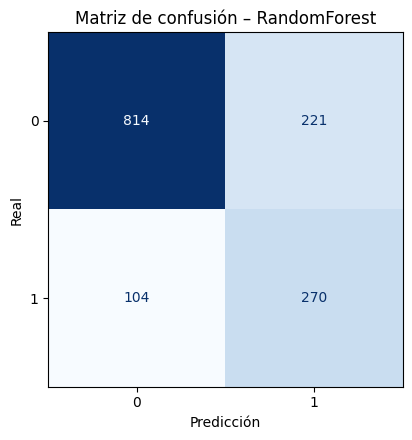

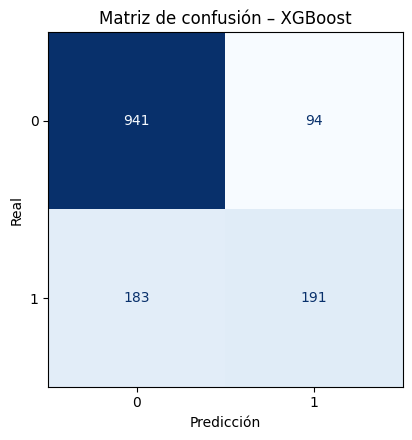

c:\Users\juana\anaconda3\envs\ml_venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


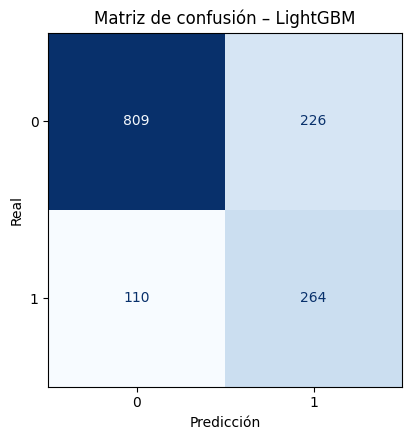

In [6]:
# ==== 5.3 Matriz de confusión (una por modelo) ====
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5.5, 4.5)

for name, model in candidates.items():
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, cmap="Blues", colorbar=False, ax=ax
    )
    ax.set_title(f"Matriz de confusión – {name}")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
    plt.tight_layout()
    plt.show()


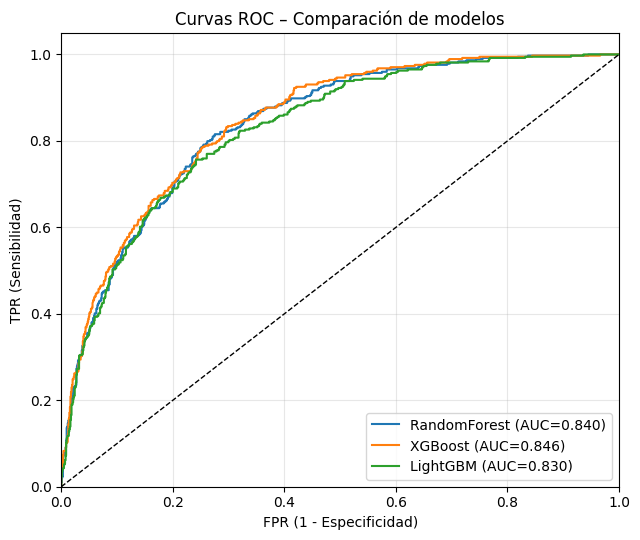

In [7]:
# ==== 5.4 Curvas ROC comparadas ====
plt.figure(figsize=(6.5, 5.5))
for name, y_prob in yprobs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], "k--", linewidth=1)
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel("FPR (1 - Especificidad)")
plt.ylabel("TPR (Sensibilidad)")
plt.title("Curvas ROC – Comparación de modelos")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


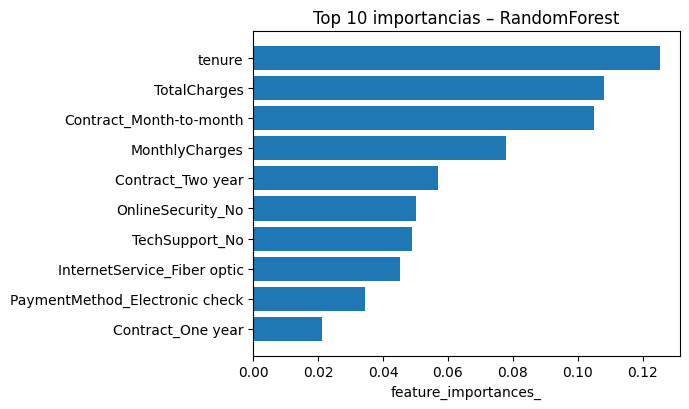

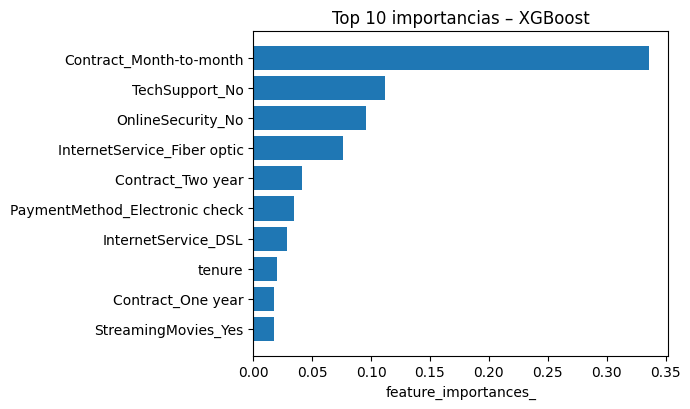

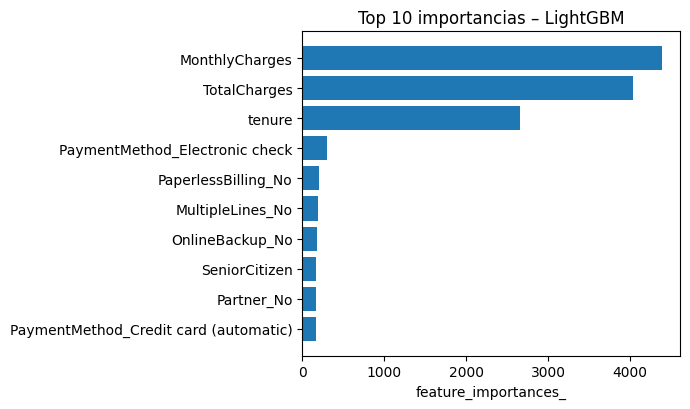

In [8]:
# ==== 5.5 Feature Importances Top-10 por modelo ====
from operator import itemgetter

def get_feature_names_from_preprocessor(pipeline):
    """
    Obtiene nombres de features después del preprocesamiento.
    Asume un pipeline con step 'pre' que implementa get_feature_names_out.
    """
    if hasattr(pipeline, "named_steps") and "pre" in pipeline.named_steps:
        pre = pipeline.named_steps["pre"]
        if hasattr(pre, "get_feature_names_out"):
            try:
                return pre.get_feature_names_out()
            except Exception:
                pass
    # fallback
    return np.array([f"feat_{i}" for i in range(
        pipeline.named_steps["clf"].n_features_in_
        if hasattr(pipeline.named_steps["clf"], "n_features_in_") else 0
    )])

def plot_top_importances(model, model_name, top=10):
    # obtener step clf y nombres de columnas del preprocesador
    if hasattr(model, "named_steps"):
        clf = model.named_steps.get("clf", model)
        feat_names = get_feature_names_from_preprocessor(model)
    else:
        clf = model
        feat_names = np.array([f"feat_{i}" for i in range(
            getattr(clf, "n_features_in_", 0)
        )])

    if not hasattr(clf, "feature_importances_"):
        print(f"⚠️ {model_name} no expone feature_importances_. Saltando.")
        return

    importances = np.asarray(clf.feature_importances_, dtype=float)
    # seguridad si longitudes no calzan:
    if len(importances) != len(feat_names):
        # recorta a la mínima longitud compatible
        n = min(len(importances), len(feat_names))
        importances = importances[:n]
        feat_names  = feat_names[:n]

    idx = np.argsort(importances)[-top:][::-1]
    plt.figure(figsize=(7, 4.2))
    plt.barh(range(len(idx)), importances[idx][::-1])
    plt.yticks(range(len(idx)), feat_names[idx][::-1])
    plt.title(f"Top {top} importancias – {model_name}")
    plt.xlabel("feature_importances_")
    plt.tight_layout()
    plt.show()

for name, model in candidates.items():
    plot_top_importances(model, name, top=10)


In [9]:
# ==== (Opcional) Guardar métricas a CSV ====
OUT = PROJECT / "docs" / "assets" / "tablas"
OUT.mkdir(parents=True, exist_ok=True)
metrics_path = OUT / "metricas_test.csv"
metrics_df.to_csv(metrics_path)
print("Métricas guardadas en:", metrics_path)


Métricas guardadas en: c:\Users\juana\MLOPS\miniproyecto6\docs\assets\tablas\metricas_test.csv
